In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables

In [2]:
interval = '60m' # 60m or 1d
history = '2y' # 2y for 60m, max for 1d
perc_inc = 0.01 # 0.008 for 60m, 0.02 for 1d (IYW)
symbol = 'JEF'
perc_train = 0.25
load_new = 0 # 0 for reuse, 1 for load new from server
current = 0 # 0 for 2nd to last data point (once markets open), 1 for last data point (when market is closed)
loc = -1 # row for previous nth interval, -2 (once market open)

In [3]:
if interval == '1d' or interval == '1wk':
    index_col = 'Date'
else:
    index_col = 'Datetime'

In [4]:
stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
stock_df.head(20)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-08-08 09:30:00-04:00,22.565542,22.893259,22.565542,22.808989,22.808989,0
2018-08-08 10:30:00-04:00,22.799625,22.883896,22.771536,22.880337,22.880337,85212
2018-08-08 11:30:00-04:00,22.883896,22.902622,22.771536,22.771536,22.771536,75244
2018-08-08 12:30:00-04:00,22.771536,22.780899,22.724720,22.746347,22.746347,57542
2018-08-08 13:30:00-04:00,22.752810,22.776217,22.743446,22.762173,22.762173,72281
2018-08-08 14:30:00-04:00,22.762173,22.827715,22.757490,22.808989,22.808989,100502
2018-08-08 15:30:00-04:00,22.808989,22.837078,22.780899,22.799625,22.799625,185398
2018-08-09 09:30:00-04:00,22.855804,22.874533,22.780899,22.818352,22.818352,0
2018-08-09 10:30:00-04:00,22.818258,22.818258,22.738764,22.780899,22.780899,120296


In [5]:
def direction(interval = interval
              , history = history
              , perc_inc = perc_inc
              , symbol = symbol
              , perc_train = perc_train
              , load_new = load_new 
              , current = current
              , loc = loc
             ):
    
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )
    
    # Load New From Server
    if load_new == 1:
        stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = False # pre/post market data
                          )
        # Create Percent Change
        stock_df['percent change'] = (stock_df.Close - stock_df.Open) / stock_df.Open

        #create decision column
        stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc

                                        , 1  # 1 if up % or greater

                                        , 0  # 0 if not up % or greater

                                       )
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions

        # Save DF to CSV
        stock_df.to_csv('stock_df.csv')
        
    else:
        if interval == '1d' or interval == '1wk':
            index_col = 'Date'
        else:
            index_col = 'Datetime'
   
        stock_df = pd.read_csv('stock_df.csv', index_col=index_col)
    
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
 
    # balance the data
    ones = stock_df_one_off.decision.value_counts()[1]
    stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)
    
    # check for NaN's
    stock_df_bal.dropna(axis=0, inplace=True)
    
    # Train Test Split
    X = stock_df_bal.drop(columns=['decision']) # get columns other than decision
    y = stock_df_bal['decision'] # get decision column
    
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , y
                                                        , test_size=0.20
                                                        , random_state = 42
                                                       )
    # 1d IYW
    # {'bootstrap': True,
    #  'max_depth': 4,
    #  'max_features': 4,
    #  'min_samples_leaf': 2,
    #  'min_samples_split': 10,
    #  'n_estimators': 5}

    # 1hr IYW
    # {'bootstrap': True,
    #  'max_depth': 4,
    #  'max_features': 3,
    #  'min_samples_leaf': 3,
    #  'min_samples_split': 5,
    #  'n_estimators': 25}
        
    # 1d JEF
    # {'bootstrap': False,
    #  'max_depth': 2,
    #  'max_features': 2,
    #  'min_samples_leaf': 1,
    #  'min_samples_split': 2,
    #  'n_estimators': 45}
    
    # 1hr JEF
    #  {'bootstrap': True,
    #  'max_depth': 2,
    #  'max_features': 6,
    #  'min_samples_leaf': 3,
    #  'min_samples_split': 5,
    #  'n_estimators': 25}

    # random forest classifier rfc
    if symbol == 'IYW' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 4
                                     , max_features = 4
                                     , min_samples_leaf = 2
                                     , min_samples_split = 10
                                     , n_estimators = 5 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    elif symbol == 'IYW' and interval == '60m':
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 4
                                     , max_features = 3
                                     , min_samples_leaf = 3
                                     , min_samples_split = 5
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    elif symbol == 'JEF' and interval == '1d':
        rfc = RandomForestClassifier(bootstrap = False
                                     , max_depth = 2
                                     , max_features = 2
                                     , min_samples_leaf = 1
                                     , min_samples_split = 2
                                     , n_estimators = 45 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    else:
        rfc = RandomForestClassifier(bootstrap = True
                                     , max_depth = 2
                                     , max_features = 6
                                     , min_samples_leaf = 3
                                     , min_samples_split = 5
                                     , n_estimators = 25 # int(perc_train * len(X_train)) # odd number
                                     , random_state = 42
                                     , verbose = 0 # no showing backend work
                                     , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                    )
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_probs = rfc.predict_proba(X_test)[:, 1]
    
    # ROC Value
    roc_value = roc_auc_score(y_test
                              , y_probs
                             )
    
    # AUC Score
    rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
    auc_value = round(auc(rf_recall, rf_prec), 3)
    
    # Feature Importances
    # feature_df = pd.DataFrame({'feature': X_train.columns
    #                            , 'importances': rfc.feature_importances_
    #                           }
    #                          ).sort_values('importances', ascending=False)
    
    # Current = 1 uses most up to date data, = 0 for one pervious current data
    if current == 1:
        loc = -1
    else:
        loc = loc
        
    # Prediction
    last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'percent change']].iloc[loc]
    if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
        result = f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.'
    else:
        result = f'Sell or hold {symbol} on the {interval} interval.'
        
    return ones, roc_value, auc_value, result

In [6]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = perc_inc
                                   , symbol = symbol
                                   , perc_train = perc_train
                                   , load_new = load_new 
                                   , current = current
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

Positives: 213
ROC Score: 0.76
AUC Score: 0.69
Sell or hold JEF on the 60m interval.


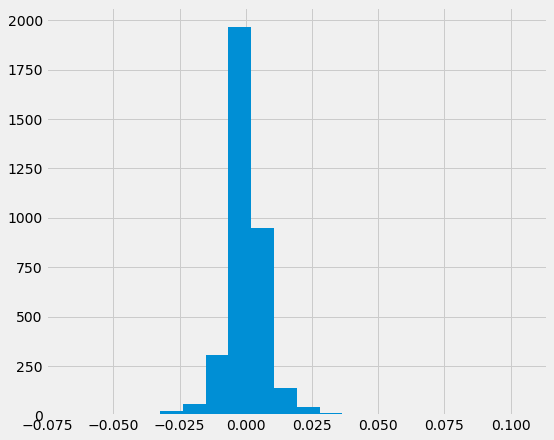

In [7]:
stock_df = pd.read_csv('stock_df.csv', index_col=index_col) # 'Date' for 1d, 'Datetime' for 60m
stock_df['percent change'].hist(bins=20)

In [8]:
stock_df['percent change'].quantile([0.84])

0.84    0.00518
Name: percent change, dtype: float64

In [9]:
perc = [x*0.01 for x in range(5,105, 5)]
perc

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]

In [10]:
roc_lst = []
auc_lst = []
results_lst = []
perc = [x*0.01 for x in range(5,105, 5)]

for x in perc:
    ones, roc, auc, result = direction(interval = interval
                                       , history = history
                                       , perc_inc = perc_inc
                                       , symbol = symbol
                                       , perc_train = x
                                       , load_new = load_new
                                       , current = current
                                      )
    roc_lst.append(roc)
    auc_lst.append(auc)
    results_lst.append(result)

results_df = pd.DataFrame({'Percent': perc
                           , 'ROC': roc_lst
                           , 'AUC': auc_lst
                           , 'Result': results_lst
                          }
                         )

In [11]:
results_df

,Percent,ROC,AUC,Result
0,0.05,0.809983,0.700,Sell or hold JEF on the 60m interval.
1,0.10,0.753999,0.680,Sell or hold JEF on the 60m interval.
2,0.15,0.758411,0.651,Sell or hold JEF on the 60m interval.
3,0.20,0.829013,0.781,Buy JEF on the 60m interval for 1.0% increase.
4,0.25,0.787369,0.741,Sell or hold JEF on the 60m interval.
5,0.30,0.791506,0.701,Sell or hold JEF on the 60m interval.
6,0.35,0.791782,0.745,Sell or hold JEF on the 60m interval.
7,0.40,0.840044,0.783,Sell or hold JEF on the 60m interval.
8,0.45,0.867623,0.770,Sell or hold JEF on the 60m interval.
9,0.50,0.824600,0.709,Sell or hold JEF on the 60m interval.


In [12]:
results_df.Result.value_counts()

Sell or hold JEF on the 60m interval.             19
Buy JEF on the 60m interval for 1.0% increase.     1
Name: Result, dtype: int64

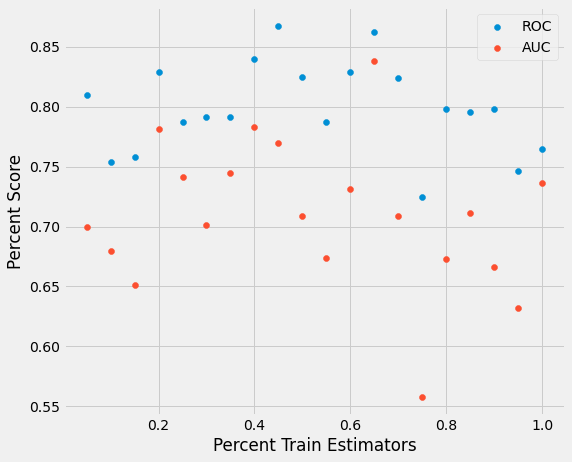

In [13]:
plt.scatter(results_df.Percent
            , results_df.ROC
            , label = 'ROC'
           )
plt.scatter(results_df.Percent
            , results_df.AUC
            , label = 'AUC'
           )
plt.xlabel('Percent Train Estimators')
plt.ylabel('Percent Score')
plt.legend();


In [14]:
results_df.loc[results_df.ROC == results_df.ROC.max()]

,Percent,ROC,AUC,Result
8,0.45,0.867623,0.77,Sell or hold JEF on the 60m interval.


In [15]:
best_perc = results_df.loc[results_df.ROC == results_df.ROC.max()].Percent.iloc[0]
best_perc

0.45

In [16]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = 0.02
                                   , symbol = symbol
                                   , perc_train = best_perc
                                   , current = 1
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

Positives: 213
ROC Score: 0.81
AUC Score: 0.69
Sell or hold JEF on the 60m interval.


In [17]:
stock_df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2020-08-05 10:30:00-04:00,16.385000,16.581301,16.385000,16.535000,16.535000,164706,0.009155,0
2020-08-05 11:30:00-04:00,16.540001,16.555000,16.495001,16.525000,16.525000,80774,-0.000907,0
2020-08-05 12:30:00-04:00,16.530001,16.580000,16.520000,16.559999,16.559999,65046,0.001815,0
2020-08-05 13:30:00-04:00,16.559999,16.629999,16.549999,16.600000,16.600000,82681,0.002416,0
2020-08-05 14:30:00-04:00,16.605000,16.660000,16.580000,16.600000,16.600000,160433,-0.000301,0
2020-08-05 15:30:00-04:00,16.605000,16.639999,16.535000,16.600000,16.600000,294355,-0.000301,0
2020-08-06 09:30:00-04:00,16.450001,16.615000,16.410000,16.600000,16.600000,139011,0.009119,0
2020-08-06 10:30:00-04:00,16.590000,16.620001,16.410000,16.420000,16.420000,66922,-0.010247,0
2020-08-06 11:30:00-04:00,16.420000,16.500000,16.395000,16.415001,16.415001,49642,-0.000304,0


### Twenty-One Calls

In [18]:
roc_scores = []
auc_scores = []
decisions = []
for _ in range(21):
    _, roc, auc, result = direction(interval = interval
                                    , history = history
                                    , perc_inc = perc_inc
                                    , symbol = symbol
                                    , perc_train = best_perc
                                    , load_new = load_new
                                    , current = current
                                   )
    roc_scores.append(roc)
    auc_scores.append(auc)
    decisions.append(result)

twenty_one_df = pd.DataFrame({'roc': roc_scores
                              , 'auc': auc_scores
                              , 'decision': decisions
                             })
twenty_one_df.decision.value_counts()

Sell or hold JEF on the 60m interval.             19
Buy JEF on the 60m interval for 1.0% increase.     2
Name: decision, dtype: int64

### Losses and Recovery

In [19]:
losses_df = pd.DataFrame({'Loss %': [0.01 * x for x in range(1,21,1)]
                          , 'Needed Gain %': [1/(1-0.01*x)-1 for x in range(1,21,1)]
                          , '% Difference': [(1/(1-0.01*x)-1-0.01*x)/(0.01*x)*100 for x in range(1,21,1)]
                         }
                        )
losses_df

,Loss %,Needed Gain %,% Difference
0,0.01,0.010101,1.010101
1,0.02,0.020408,2.040816
2,0.03,0.030928,3.092784
3,0.04,0.041667,4.166667
4,0.05,0.052632,5.263158
5,0.06,0.063830,6.382979
6,0.07,0.075269,7.526882
7,0.08,0.086957,8.695652
8,0.09,0.098901,9.890110
9,0.10,0.111111,11.111111
